<a href="https://colab.research.google.com/github/shubhamatkal/ml-notebooks/blob/main/img-compression-svd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
print("Hello")

Hello


Saving spotify-utility.png to spotify-utility (1).png


(np.float64(-0.5), np.float64(760.5), np.float64(760.5), np.float64(-0.5))

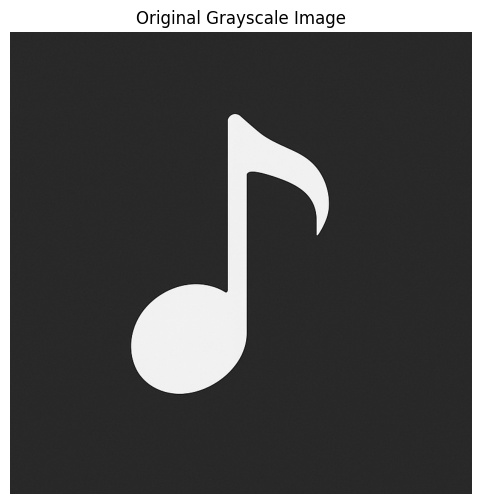

In [2]:
from google.colab import files
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Upload image
uploaded = files.upload()

# Load the uploaded image
filename = list(uploaded.keys())[0]
img = Image.open(filename)

# Convert to grayscale for simplicity first
img_gray = img.convert("L")
img_array = np.array(img_gray)

plt.figure(figsize=(6,6))
plt.title("Original Grayscale Image")
plt.imshow(img_array, cmap='gray')
plt.axis("off")

In [4]:
img_array[0]

array([42, 41, 41, 43, 40, 41, 39, 42, 41, 41, 42, 40, 41, 41, 39, 41, 41,
       41, 39, 40, 41, 40, 39, 41, 40, 41, 41, 41, 40, 40, 42, 42, 43, 40,
       40, 40, 41, 42, 42, 42, 40, 41, 41, 41, 41, 41, 41, 42, 40, 39, 43,
       42, 40, 41, 40, 40, 43, 42, 41, 41, 41, 42, 41, 41, 43, 41, 41, 42,
       42, 42, 44, 40, 41, 42, 40, 42, 43, 43, 41, 39, 40, 41, 43, 39, 40,
       40, 40, 41, 41, 41, 41, 41, 41, 40, 42, 42, 40, 40, 41, 39, 40, 41,
       42, 40, 40, 41, 41, 42, 42, 41, 41, 41, 40, 42, 42, 41, 40, 40, 41,
       39, 40, 43, 41, 41, 40, 41, 41, 43, 43, 41, 41, 43, 40, 41, 41, 41,
       42, 44, 42, 41, 41, 40, 40, 40, 40, 41, 43, 41, 41, 41, 41, 40, 40,
       41, 41, 42, 41, 40, 40, 40, 39, 41, 42, 41, 41, 40, 40, 39, 40, 40,
       41, 41, 40, 40, 41, 42, 42, 41, 40, 42, 42, 41, 41, 42, 40, 41, 41,
       40, 41, 40, 40, 41, 41, 41, 40, 40, 42, 43, 42, 39, 39, 39, 41, 41,
       40, 42, 41, 40, 42, 41, 41, 40, 40, 43, 40, 42, 41, 41, 41, 40, 41,
       42, 41, 41, 40, 41

In [5]:
import numpy as np

def svd_compress(img_array, k):
    # Compute full SVD
    U, S, Vt = np.linalg.svd(img_array, full_matrices=False)

    # Keep only top-k singular values
    S_k = np.diag(S[:k])
    U_k = U[:, :k]
    Vt_k = Vt[:k, :]

    # Reconstruct compressed image
    compressed = U_k @ S_k @ Vt_k
    return compressed

In [ ]:
!pip install ipywidgets
from ipywidgets import interact, IntSlider
import matplotlib.pyplot as plt

def show_compressed(k):
    compressed = svd_compress(img_array, k)
    plt.figure(figsize=(6,6))
    plt.title(f"Compressed Image (k = {k})")
    plt.imshow(compressed, cmap='gray')
    plt.axis("off")

# Interactive slider
interact(
    show_compressed,
    k=IntSlider(min=5, max=min(img_array.shape), step=5, value=50)
);

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 53.6 MB/s eta 0:00:00


interactive(children=(IntSlider(value=50, description='k', max=761, min=5, step=5), Output()), _dom_classes=('…

Compress colour image using svd

In [6]:
# Run this entire cell in Google Colab

# Install widget support (Colab sometimes needs this)
!pip install -q ipywidgets
from google.colab import files
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, VBox, HBox, Button, Layout, Output
import io
import os
import math

# -------------------------
# Utilities
# -------------------------
def svd_reconstruct_channel(channel, k):
    # channel: 2D numpy array (H x W)
    # compute truncated SVD and reconstruct with top-k components
    U, S, Vt = np.linalg.svd(channel, full_matrices=False)
    k = min(k, S.shape[0])
    U_k = U[:, :k]
    S_k = S[:k]
    Vt_k = Vt[:k, :]
    # Reconstruct using vectorized multiplication
    return (U_k * S_k) @ Vt_k  # shape H x W

def compress_color_image(img_array, k):
    # img_array: H x W x 3 (uint8 or float)
    # returns reconstructed image (float), and sizes for compression ratio
    H, W, C = img_array.shape
    recon = np.zeros_like(img_array, dtype=float)
    orig_size = H * W * C  # number of values
    kept = 0
    for ch in range(3):
        channel = img_array[..., ch].astype(float)
        recon_ch = svd_reconstruct_channel(channel, k)
        recon[..., ch] = recon_ch
        # For storage estimate: U_k (H*k), S_k (k), Vt_k (k*W)
        kept += (H * k) + k + (k * W)
    # compression ratio approx: kept / orig_size
    compression_ratio = kept / orig_size
    return recon, compression_ratio

def mse(img1, img2):
    img1 = img1.astype(float)
    img2 = img2.astype(float)
    return np.mean((img1 - img2) ** 2)

def psnr(img1, img2, max_pixel=255.0):
    m = mse(img1, img2)
    if m == 0:
        return float('inf')
    return 20 * math.log10(max_pixel / math.sqrt(m))

def to_uint8_clip(img):
    img_clipped = np.clip(img.round(), 0, 255).astype(np.uint8)
    return img_clipped

# -------------------------
# UI / Interaction
# -------------------------
upload_out = Output()
display_out = Output()
download_out = Output()
info_out = Output()

# Upload image
with upload_out:
    print("Upload an image (PNG/JPG). After upload, wait a moment for display widgets to appear.")
uploaded = files.upload()
if len(uploaded) == 0:
    raise SystemExit("No file uploaded.")
filename = list(uploaded.keys())[0]
img = Image.open(filename).convert("RGB")
img_array = np.array(img)
H, W = img_array.shape[:2]

# Show original
with display_out:
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    ax.imshow(img_array)
    ax.set_title(f"Original (shape={H}x{W})")
    ax.axis('off')
    plt.show()

# Prepare slider bounds
max_k = min(H, W)
start_k = min(50, max_k)  # default
step_k = 1 if max_k <= 200 else 5

# Buttons and outputs
save_button = Button(description="Save & Download Current Compressed Image", button_style='success', layout=Layout(width='320px'))
out_img_for_download = {'img': None, 'k': None}  # holder

def update_and_show(k):
    """This function is called by the slider (interactive)."""
    display_out.clear_output(wait=True)
    info_out.clear_output(wait=True)
    download_out.clear_output(wait=True)
    with display_out:
        recon_float, comp_ratio = compress_color_image(img_array, k)
        recon_uint8 = to_uint8_clip(recon_float)
        out_img_for_download['img'] = recon_uint8
        out_img_for_download['k'] = k

        fig, axes = plt.subplots(1,2, figsize=(12,6))
        axes[0].imshow(img_array)
        axes[0].set_title("Original")
        axes[0].axis('off')

        axes[1].imshow(recon_uint8)
        axes[1].set_title(f"Compressed (k={k})")
        axes[1].axis('off')

        plt.show()

    # Show PSNR and compression info
    with info_out:
        m = mse(img_array, recon_uint8)
        p = psnr(img_array, recon_uint8)
        print(f"k = {k}   |   Estimated kept entries ratio ≈ {comp_ratio:.4f} (lower is more compression)")
        print(f"MSE = {m:.2f}   |   PSNR = {p:.2f} dB")
        if p == float('inf'):
            print("(Perfect reconstruction)")

# Slider
slider = IntSlider(value=start_k, min=1, max=max_k, step=step_k, description='k', continuous_update=False, layout=Layout(width='70%'))
def on_slider_change(change):
    if change['name'] == 'value':
        update_and_show(change['new'])

slider.observe(on_slider_change)

# Save/download button callback
def save_and_download(b):
    download_out.clear_output()
    if out_img_for_download['img'] is None:
        with download_out:
            print("No compressed image available yet. Move the slider first.")
        return
    k = out_img_for_download['k']
    img_to_save = Image.fromarray(out_img_for_download['img'])
    save_name = f"compressed_k{k}_" + os.path.splitext(filename)[0] + ".png"
    img_to_save.save(save_name)
    # Use google.colab.files to download
    with download_out:
        print(f"Saved {save_name}. Preparing download...")
    files.download(save_name)

save_button.on_click(save_and_download)

# Initial render
update_and_show(slider.value)

# Layout
ui = VBox([
    upload_out,
    HBox([slider, save_button], layout=Layout(align_items='center')),
    display_out,
    info_out,
    download_out
])
display(ui)


Saving Red and Black Retro Landscape YouTube Thumbnail background.png to Red and Black Retro Landscape YouTube Thumbnail background.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>